Aya Eid

Tempus Test Case

# Include imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

# Reading in and structuring data

Three files were provided and I assumed the features from the biomarkers file and those from the patient profiles were not redundant.  So in this section, I combine the features from biomarkers, the features from  patient profiles and the targets into a master data matrix, which I call "data".  

In [127]:
targets = pd.read_csv('targets.csv')
data = pd.read_csv('biomarkers.csv')

In [128]:
# Connect biomarker and target data through biomarker_id in master data matrix
data.insert(0,'patient_id', np.full(len(data),np.nan))
data.insert(1,'target', np.full(len(data),np.nan))

for b_iter in range(0, len(targets)):  
    bid = targets.loc[b_iter]['biomarker_id']  
    data.loc[data.biomarker_id==bid,'patient_id'] = targets.loc[b_iter,'patient_id']
    data.loc[data.biomarker_id==bid,'target'] = targets.loc[b_iter,'target_label']


In [129]:
data.head()

,patient_id,target,biomarker_id,BM00000,BM00001,BM00002,BM00003,BM00004,BM00005,BM00006,...,BM15147,BM15148,BM15149,BM15150,BM15151,BM15152,BM15153,BM15154,BM15155,BM15156
0,2293769a5,0.0,100505de2,1,1,1,0,0,0,1,...,1,0,1,1,0,0,1,1.0,1,1
1,221da90e,1.0,10075c5c2,1,1,1,0,0,0,1,...,1,0,0,0,0,0,1,NaN,1,1
2,f379252a,1.0,10105cb22,1,1,1,0,0,0,1,...,1,0,0,0,0,0,1,NaN,1,1
3,1c9af69ad,0.0,101219d6e,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,1.0,1,1
4,378b948f,0.0,10135ad45,1,0,1,0,1,0,1,...,1,0,1,0,0,0,1,1.0,1,1


In [130]:
# Next we connect the patient profile data to master data through the patient id  
# while this isn't the fastest, it could be optimized or parallelized for larger datasets
with open("patient_profiles.json", "r") as read_file:
    patient_profiles = json.load(read_file)

def check(val):
    if val:
        return val
    else:
        return np.nan
    
data['institution'] = np.full(len(data),np.nan)
data['gender'] = np.full(len(data),np.nan)
data['age'] = np.full(len(data),np.nan)
data['race'] = np.full(len(data),np.nan)
data['dst'] = np.full(len(data),np.nan)
data['comind'] = np.full(len(data),np.nan)
data['coq'] = np.full(len(data),np.nan)
data['smoking'] = np.full(len(data),np.nan)
data['msd'] = np.full(len(data),np.nan)

for inst_iter in range(0,len(patient_profiles)):
    print('Progress read in: ', inst_iter/(len(patient_profiles)-1))
          
    for p_iter in range(0,len(patient_profiles[inst_iter]['patient_profiles'])):           
        pid = patient_profiles[inst_iter]['patient_profiles'][p_iter]['patient_id']
        ploc = data['patient_id']==pid

        if(np.sum(ploc)>0):
            data.loc[data['patient_id']==pid,'institution'] = check(patient_profiles[inst_iter]['institution'])
            data.loc[data['patient_id']==pid,'gender'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['demographics'].get('gender'))
            data.loc[data['patient_id']==pid,'age'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['demographics'].get('age'))        
            data.loc[data['patient_id']==pid,'race'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['demographics'].get('race'))
            data.loc[data['patient_id']==pid,'dst'] = patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('disease_sub_type')
            
            data.loc[data['patient_id']==pid,'comind'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('comorbidity_index'))
            data.loc[data['patient_id']==pid,'coq'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('cohort_qualifier'))
            data.loc[data['patient_id']==pid,'smoking'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('smoking_status'))
            data.loc[data['patient_id']==pid,'msd'] = check(patient_profiles[inst_iter]['patient_profiles'][p_iter]['status'].get('months_since_diagnosis'))
              

Read in:  0.0
Read in:  0.16666666666666666
Read in:  0.3333333333333333
Read in:  0.5
Read in:  0.6666666666666666
Read in:  0.8333333333333334
Read in:  1.0


In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Columns: 15169 entries, patient_id to msd
dtypes: float64(50), int64(15111), object(8)
memory usage: 226.8+ MB


# Data Cleaning

Now I go through some basic approaches to ensuring the data can be handled by the model.  My process includes removing observations without targets, removing features that have too many missing values, and filling in missing values (although certain algorithms XGB for example could handle missing values).  For categorical data I used one-hot encoding to convert them into numerical inputs. 

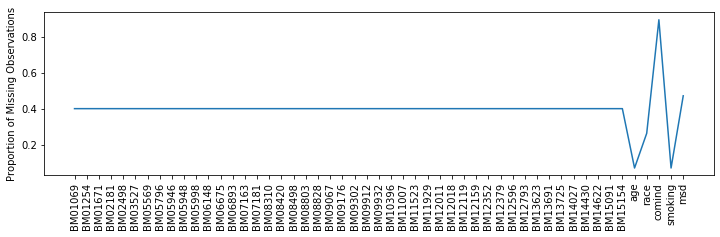

In [309]:
# Remove any observations without target data
dataCleaned = data.copy();
dataCleaned.dropna(subset=['target'],inplace=True)  

# Let's take a look at how many features have missing values and how many 
ratioOfNans = dataCleaned.isnull().sum()/len(dataCleaned)
plt.figure(figsize=(12,3))
plt.plot(ratioOfNans[ratioOfNans>0])
plt.xticks(rotation=90) 
plt.ylabel('Proportion of Missing Observations')
plt.show()

In [310]:
# For simplicity, let's just remove any features with more than 5% missing values
dataCleaned.dropna(axis=1, thresh = 100, inplace=True)

In [311]:
# Now for the categorical features, let's use one-hot encoding
cat_feats = ['institution','dst','gender','race','smoking']  # categorical features

# Here I use a simple approach to ensuring the categories would bin appropriately (eg MALE and male were considered the same observation)
dataCleaned = dataCleaned.applymap(lambda s:s.lower() if type(s) == str else s)  
dataCleaned = pd.get_dummies(dataCleaned, columns=cat_feats, drop_first=True)

# Here I found one feature that came from an input of "unknown" which is synomous with "NaN"
# another approach is to replace all table values of "unknown" with "NaN" earlier. But this was the only feature in which I saw this
dataCleaned.drop('smoking_unknown',axis=1,inplace=True)  
dataCleaned.fillna(0,inplace=True)  # not an ideal fill, but I wanted to keep it simple.  Also, XGBoost can handle them (future iteration)

In [312]:
# let's take a look at the new features
dataCleaned.iloc[:,-25:].head()

,BM15153,BM15154,BM15155,BM15156,age,comind,coq,msd,institution_goodfellow research institute,institution_johnson & bloom hospitals,...,dst_d,dst_e,dst_f,gender_male,race_asian,race_black or african american,race_native hawaiian or other pacific islander,race_white,smoking_former,smoking_never
0,1,1.0,1,1,0.0,0.0,True,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0.0,1,1,29.0,0.0,True,79.0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,0.0,1,1,66.0,1.0,True,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,1,1.0,1,1,69.0,0.0,True,0.0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,1.0,1,1,56.0,0.0,True,0.0,0,0,...,0,0,0,0,0,1,0,0,0,1


KeyError: "None of [Float64Index([0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,\n              ...\n              1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],\n             dtype='float64', length=1734)] are in the [columns]"

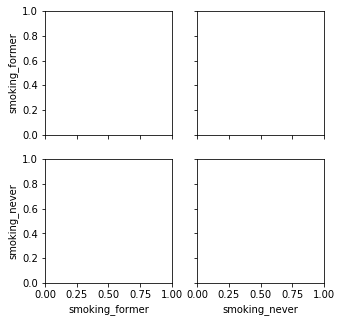

In [215]:
sns.pairplot(dataCleaned.iloc[:,-2:],hue=dataCleaned['target'])#,hue=dataCleaned['target'])
#ax = sns.countplot(x = ['BM10516','age'], hue="target", data = dataCleaned)

# Building a model

Now the data is prepared, I made a couple first order attempts at building the model.  To do this I first separate training and test sets.  I started with a RF classifier to get a baseline of predictor strength.  It was clear the data was imbalanced and a boosted algorithm would improve the model.  I then used the Gradient Boosting Classifier and found marked improvement.  Finally, I performed some basic parameter tuning, but found the 

In [313]:
# First separate the data into test and train sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
X = dataCleaned.drop(['target','biomarker_id','patient_id'],axis=1)
y = dataCleaned['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [314]:
# Here we get a feeling for how well a RF classifier will do
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, random_state=101)
model.fit(X_train, y_train)
predictions = np.round(model.predict(X_test))

print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))

# We see here because this model is a bit imbalanced, 
# the best resulting model is as good as naively classifying all outputs as negatives. 
# While the TN rate is good, the TP is terrible
# This is an ideal data set for a boosted approach 

              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88       521
         1.0       0.00      0.00      0.00         0

    accuracy                           0.78       521
   macro avg       0.50      0.39      0.44       521
weighted avg       1.00      0.78      0.88       521

[[406 115]
 [  0   0]]


C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Model Report
Accuracy : 0.8829
AUC Score (Test): 0.932

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       455
         1.0       0.52      0.91      0.66        66

    accuracy                           0.88       521
   macro avg       0.75      0.89      0.80       521
weighted avg       0.93      0.88      0.90       521


Confusion Matrix
[[400  55]
 [  6  60]]

Model Paramters
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=101, subsample=1.0, to

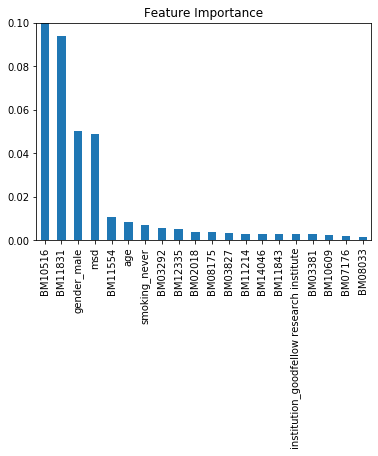

In [356]:
from sklearn import metrics 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV

# First order model (no parameter tuning...yet)
model = GradientBoostingClassifier(random_state=101, n_estimators=50)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

# Print model report
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, pred_prob))
print(classification_report(predictions, y_test))

print("\nConfusion Matrix")
print(confusion_matrix(predictions, y_test))

print('\nModel Paramters')
print(model)

# Let's take a look at which features are playing the biggest role
f_imp = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False)
f_imp.iloc[0:20].plot(kind='bar', title='Feature Importance')
plt.ylim([0,.1])
plt.show()


In [327]:
# Tuning n_estimators for a learning rate of 0.1
# if the best value is found to be greater than 100 (as limited by the computational power of mylaptop)
# then I'll have to increase the LR
param_test = {'n_estimators':range(25,201,25)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                                               min_samples_split = 2,
                                                               min_samples_leaf = 1,
                                                               max_depth = 3, 
                                                               max_features = None,
                                                               subsample = 0.8, 
                                                               random_state = 101), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=4, iid=False, cv=5, verbose=1)
gsearch.fit(X_train,y_train)
n_estimators_B = gsearch.best_params_['n_estimators']
gsearch.best_params_, gsearch.best_score_


# Finding a value of 50 shows the LR may be just fine

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 10.6min finished


({'n_estimators': 50}, 0.9241551993190524)

In [365]:
# Let's tune max_depth to keep to smaller trees and prevent overfitting
param_test = {'max_depth':range(1,10,1)}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                                              n_estimators = n_estimators_B,
                                                              max_features = None,
                                                              min_samples_split = 2, 
                                                              min_samples_leaf = 1,
                                                              subsample = 0.8, 
                                                              random_state = 101), 
                        param_grid = param_test, scoring='roc_auc', n_jobs=4, iid=False, cv=3, verbose=1)
gsearch.fit(X_train,y_train)
max_depth_B = gsearch.best_params_['max_depth']
gsearch.best_params_, gsearch.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  23 out of  27 | elapsed:  6.5min remaining:  1.1min
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  8.8min finished


({'max_depth': 5}, 0.9264196321122791)


Model Report
Accuracy : 0.8925
AUC Score (Test): 0.926
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       444
         1.0       0.59      0.88      0.71        77

    accuracy                           0.89       521
   macro avg       0.78      0.89      0.82       521
weighted avg       0.92      0.89      0.90       521


Confusion Matrix
[[397  47]
 [  9  68]]

Model Paramters
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=101, subsample=0.8, tol=0

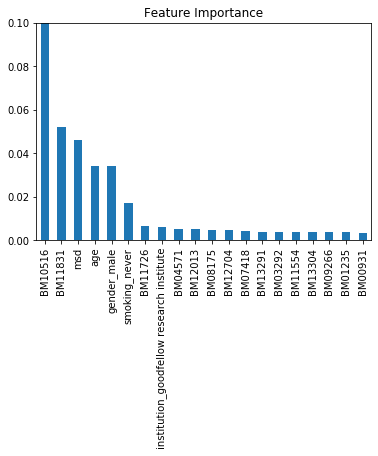

In [372]:
# Second order model
model = GradientBoostingClassifier(random_state = 101, 
                                   learning_rate = 0.1, 
                                   n_estimators = n_estimators_B, 
                                   max_depth = max_depth_B, 
                                   min_samples_split = 2, 
                                   min_samples_leaf = 1,
                                   subsample = 0.8)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
pred_prob = model.predict_proba(X_test)[:,1]

# Print model report
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, pred_prob))
print(classification_report(predictions, y_test))

print("\nConfusion Matrix")
print(confusion_matrix(predictions, y_test))

print('\nModel Paramters')
print(model)

# Let's take a look at which features are playing the biggest role
f_imp = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False)
f_imp.iloc[0:20].plot(kind='bar', title='Feature Importance')
plt.ylim([0,.1])
plt.show()

At a bit of a cost to the TN rate, we see a marked improvement in the TP rate, yielding an overall improvement in accuracy.  We see this in an unchanged F1-score for targets of 0, and improved F1-sore for targets of 1.  

In [351]:
# # Tuning max_depth and min_samples_split
# param_test = {'max_depth':range(1,8,1), 'min_samples_split':range(2,101,10)}
# gsearch = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.05, 
#                                                                n_estimators = n_estimators_B,
#                                                                max_features = max_features_B, 
#                                                                subsample = 0.8, 
#                                                                random_state = 101), 
#                         param_grid = param_test, scoring='roc_auc', n_jobs=4, iid=False, cv=5,verbose=10)
# gsearch.fit(X_train, y_train)
# max_depth_B = gsearch.best_params_['max_depth']
# #min_samples_split_B = gsearch.best_params_['min_samples_split']

# gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   41.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  3.1min
[Parallel(

KeyError: 'max_depth'

In [364]:
gsearch.cv_results_

{'mean_fit_time': array([ 13.64224021,  24.98020554,  39.7746892 ,  57.31278396,
         80.47684741, 105.32833497, 145.33351707, 153.78347858]),
 'std_fit_time': array([ 0.08000497,  0.29568199,  0.244759  ,  0.95035176,  0.88339582,
         3.8945603 ,  2.42693935, 11.90430409]),
 'mean_score_time': array([0.79720712, 0.86681517, 0.91345374, 0.90566389, 0.94863248,
        1.12117386, 1.05875834, 0.59939639]),
 'std_score_time': array([0.01657009, 0.09305539, 0.02051317, 0.04591848, 0.0171646 ,
        0.17372961, 0.09887241, 0.14943406]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9}],
 'split0_test_score': array([0.93059309, 0.92881525, 0.9244062 , 0.92184611, 0.9250817


Model Report
Accuracy : 0.8925
AUC Score (Test): 0.926
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93       444
         1.0       0.59      0.88      0.71        77

    accuracy                           0.89       521
   macro avg       0.78      0.89      0.82       521
weighted avg       0.92      0.89      0.90       521

[[397  47]
 [  9  68]]


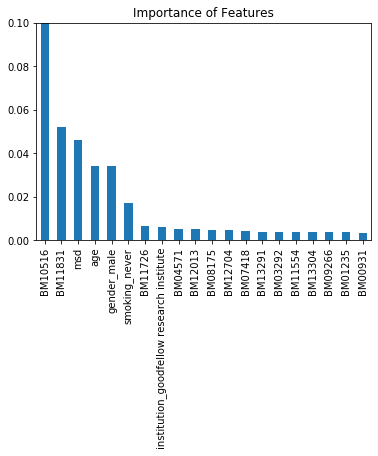

In [363]:
# Second order model
model = GradientBoostingClassifier(random_state = 101, 
                                   learning_rate = 0.1, 
                                   n_estimators = n_estimators_B, 
                                   max_depth = max_depth_B, #
                                   min_samples_split = 2,#min_samples_split_B, #                                   max_features = max_features_B, 
                                   subsample = 0.8)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predprob = model.predict_proba(X_test)[:,1]
#cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

# Print model report
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, predprob))
#print("CV Score : Mean = %.7g | Std = %.7g | Min = %.7g | Max = %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))    
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))


feat_imp = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False)
feat_imp.iloc[0:20].plot(kind='bar', title='Importance of Features')
plt.ylim([0,.1])
plt.show() 



Model Report
Accuracy : 0.8829
AUC Score (Test): 0.842
CV Score : Mean = 0.5448971 | Std = 0.02682569 | Min = 0.4986523 | Max = 0.5808342
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       455
         1.0       0.52      0.91      0.66        66

    accuracy                           0.88       521
   macro avg       0.75      0.89      0.80       521
weighted avg       0.93      0.88      0.90       521

[[400  55]
 [  6  60]]


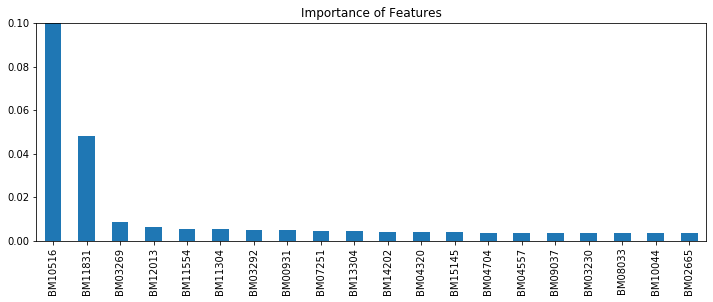

In [129]:

print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, predictions))
print("AUC Score (Test): %4.3f" % metrics.roc_auc_score(y_test, predprob))
print("CV Score : Mean = %.7g | Std = %.7g | Min = %.7g | Max = %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))    
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))
feat_imp = pd.Series(model.feature_importances_, list(X_train)).sort_values(ascending=False)
feat_imp.iloc[0:20].plot(kind='bar', title='Importance of Features')
plt.ylim([0,.1])
plt.show()


In [89]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
rf_exp = RandomForestRegressor(n_estimators= 500, random_state=100)
#rf_exp = RandomForestClassifier(n_estimators= 500, random_state=100, criterion='gini')
rf_exp.fit(X_train, y_train)
predictions = np.round(rf_exp.predict(X_test))

print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [90]:
#np.mean(np.round(predictions)!=test_labels)
predictions = np.round(predictions)
#predictions2 = False * np.ones(predictions.shape)
print(classification_report(predictions, y_test))
print(confusion_matrix(predictions, y_test))


              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       764
         1.0       0.50      0.91      0.64       103

    accuracy                           0.88       867
   macro avg       0.74      0.89      0.79       867
weighted avg       0.93      0.88      0.89       867

[[669  95]
 [  9  94]]


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87       572
         1.0       0.00      0.00      0.00         1

    accuracy                           0.77       573
   macro avg       0.50      0.39      0.44       573
weighted avg       1.00      0.77      0.87       573

[[443 129]
 [  1   0]]


# Neural Network

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1)) 
model.compile(optimizer='rmsprop',loss='mse')  # optimzer depends on type of problem (binary, multiclass or regression)

model.fit(x=X_train,y=y_train, epochs=250,verbose=0)
predictions = np.round(model.predict(X_test))
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))


In [14]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [16]:
predictions = dtree.predict(X_test)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       478
           1       0.11      0.22      0.14        54

    accuracy                           0.73       532
   macro avg       0.50      0.51      0.49       532
weighted avg       0.82      0.73      0.77       532

[[377 101]
 [ 42  12]]


In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [18]:
clf.feature_importances_
predictions = clf.predict(X_test)

print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88       524
           1       0.03      0.38      0.05         8

    accuracy                           0.78       532
   macro avg       0.51      0.58      0.46       532
weighted avg       0.97      0.78      0.87       532

[[414 110]
 [  5   3]]


In [19]:
from sklearn.ensemble import RandomForestClassifier

[[375 101]
 [ 44  12]]


              precision    recall  f1-score   support

           0       0.89      0.79      0.84       476
           1       0.11      0.21      0.14        56

    accuracy                           0.73       532
   macro avg       0.50      0.50      0.49       532
weighted avg       0.81      0.73      0.76       532



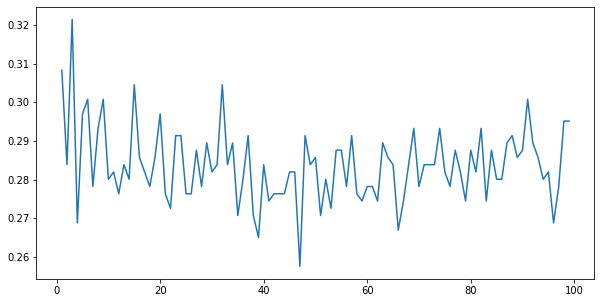

In [22]:
err = []
for i in range(1,100):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X_train, y_train)
    rfc_predictions = rfc.predict(X_test)
    err.append(np.mean(rfc_predictions!=y_test))
    #err.append(f1_score(y_test, rfc_predictions, average='weighted'))

plt.figure(figsize=(10,5))
plt.plot(range(1,100),err)  

rfc = RandomForestClassifier(n_estimators=11)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
#err.append(np.mean(rfc_predictions!=y_test))    
    
print(confusion_matrix(rfc_predictions,y_test))
print('\n')
print(classification_report(rfc_predictions,y_test))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1,100),err)    

In [23]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[419   0]
 [113   0]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       419
           1       0.00      0.00      0.00       113

    accuracy                           0.79       532
   macro avg       0.39      0.50      0.44       532
weighted avg       0.62      0.79      0.69       532



C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:

# C controls the cost of misclassification of training
# large C gives low bias and high variance (overfitting) because you penalize the cost of misclassification
# low C underfits (high bias, low variance)

# gamma: radial basis function, gamma is a free param in it, small gamma gives a gaussian with a higher vairnace
# large gamma -> high variance low bias
# default gamma = 1/n_features
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[.001, .01, 0.1], 'gamma':[10,1,.1]}
grid = GridSearchCV(SVC(), param_grid, verbose=3)
grid.fit(X_train, y_train)
grid.best_params_
grid.best_estimator_
grid_predictions = grid.predict(X_test)


In [ ]:
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))
grid.best_params_

In [24]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=500)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

C:\Users\ayaei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


NameError: name 'grid_predictions' is not defined

In [ ]:
logmodel

In [ ]:
#data['dst'].loc[data['biomarker_id']==pid] = check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('disease_sub_type')
                                                   
                                                   
#check(patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status'].get('disease_sub_type'))
data['dst'].loc[data['biomarker_id']==pid]
data.loc[data['biomarker_id']==pid]
data.head(20)


def check(val):
    if val:
        return val
    else:
        return np.nan
    
    
print(check(patient_profiles[inst_ind]["patient_profiles"][0]['demographics'].get('race')))
print(check(patient_profiles[inst_ind]["patient_profiles"][1]['demographics'].get('race')))


print(check(patient_profiles[1]["patient_profiles"][2]['demographics'].get('race')))

print(check(patient_profiles[6]["patient_profiles"][0]['demographics'].get('race')))



#data['dst'].loc[data['biomarker_id']==pid] = patient_profiles[inst_ind]["patient_profiles"][pat_ind]['status']['disease_sub_type']
        
#data.head()    
#data.isin(['89c43bb4'])    
#data[data['biomarker_id']=='89c43bb4']['institution'] = patient_profiles[0]["institution"]
#data['institution'].loc[data['biomarker_id']=='89c43bb4'] = patient_profiles[0]["institution"]

#inst_ind = 1
#pat_ind = 2
#patient_profiles[inst_ind]["patient_profiles"][pat_ind]['patient_id']
#patient_profiles[inst_ind]["patient_profiles"][pat_ind]['demographics']['gender']


In [ ]:
data.head()

In [ ]:
#len(patient_profiles[0]["patient_profiles"])
#pid = patient_profiles[0]["patient_profiles"][0]['patient_id']
#pid
#data.loc['10e32947f']

patient_profiles[0]["institution"]

In [ ]:
print(json.dumps(patient_profiles, indent=4))
#patient_profiles[2]["institution"]
